# Charge profile optimization - M3

Ref: Hoke 2011 [Electric Vehicle Charge Optimization Including
Effects of Lithium-Ion Battery Degradation]

We add a term to account for battery degradation related to capacity fade attributable to state of charge (SOC). The linear relationship between SOC and battery degradation is adapted from Hoke 2011 with arbitrary parameters m and d. In these models, all costs terms are deemed additive, without distinction between charge and power fade. This allow to capture dynamics of profile charge, but under this simplification an expected vehicle lifetime cannot be estimated.

Model 1:
- An electric vehicle (EV) can charge within a time window (t_min;t_max), from a charge infrastructure with varying electricity prices.

Model 2:
- Both V2G and G2V charges are allowed: the EV acts as a battery that helps balance offer and demand.
- However, charging degrades the battery, and this is accounted by an Arrhenius relationship inspired from Hoke 2011, here with arbitrary parameters.

Model 3:
- Furthermore, battery degradation associated attributable to SOC is accounted for. Minimal SOC of 0.2 is set to be consistent with Hoke 2011 mention of manufacturer-specified battery vehicle protection controls. 

Key observations:
- V2G charge occurs at higher electricity prices, while G2V occurs at lower prices. This behavior has economic interests for the consumer, and would help balance the grid demand and offer if the electricity prices translate (as they should).
- The higher degradation encountered at higher power charges is captured here (although with arbitrary parameters): as higher charges are associated with increase in temperature and thus increased battery degradation, charge profile occur at a constant power on periods of constant electricity prices (e.g. two consecutive 3kWh charges are preferred to one 6kWh charge and one null charge). Without this effect, for instance with a degradation linear to the power charge, charge powers are herratic (not shown here). 
- Coherent with Hoke 2011, charging is delayed to prevent long period with high SOC. A balance is found between reducing high charge power while also reducing amount of time spent with high SOC.

In [31]:
import numpy as np
import scipy
import seaborn as sns; sns.set_style("whitegrid");

In [46]:
# Electricity market

TIME_PERIOD_HOURS = 24 # starts at noon=0
# Costs based on approximation of EDF's "Tarif Bleu", august 2020 (https://www.jechange.fr/energie/electricite/guides/prix-electricite-kwh-2435)
LOW_COST = 0.1377
HIGH_COST = 0.1781
ELECTRICITY_COSTS = [LOW_COST]*5 + [HIGH_COST]*4 + [LOW_COST]*10 + [HIGH_COST]*5  # 12h-17h, 17h-21h, 21h-7h, 7H-12h

# Vehicle

STATE_OF_CHARGE_T0 = 0.30
STATE_OF_CHARGE_TCH = 0.90
Q_KWH = 30
BATTERY_COST = Q_KWH*156*0.84 # euros
# based on 2019 average price as reported in 
# https://about.bnef.com/blog/battery-pack-prices-fall-as-market-ramps-up-with-market-average-at-156-kwh-in-2019/
STATE_OF_CHARGE_LOWER_BOUND = 0.2
STATE_OF_CHARGE_HIGHER_BOUND = 0.90


m = 1/10 # ARBITRARY
d = 0 # ARBITRARY
CF_MAX_x_CONSTANT = 0.2*15*8760

def soc_penalization(soc_avg):
    """
        :param soc_avg: average SOC during the cycle.
        :return: cost associated with average SOC.
    """
    return BATTERY_COST*(m*soc_avg-d)/CF_MAX_x_CONSTANT

# Charge system

CHARGE_POWER_LOWER_BOUND_KWH = -6.6
CHARGE_POWER_HIGHER_BOUND_KWH = 6.6

def degradation_function(p_):
    """
        :param p_: (signed) power charge
        :return: cost associated to power charge (euros)
        
        Degradation is expressed as ratio of total battery lifecycle reduction, and multiplied with total battery cost.
        Form of the function is borrowed from Hoke 2011, with the approximation that temperature would rise
        with higher power charge. The actual environment temperature is considered constant here, and allow charge
        related temperature increase is considered. Parameters a and b are arbitrary.
    """

    return BATTERY_COST*(10**-5)*(np.exp(0.05*abs(p_)/CHARGE_POWER_HIGHER_BOUND_KWH))

# DEGRADATION_BY_KWH = 0
# User
T_MIN = 1 # vehicle is plugged
T_MAX = 22  # Vehicle to be charged before 7am

[Text(0.5, 0, 'State of Charge (SOC)'),
 Text(0, 0.5, 'Battery degradation (euros)'),
 Text(0.5, 1.0, 'SOC penalization function for accepted SOC')]

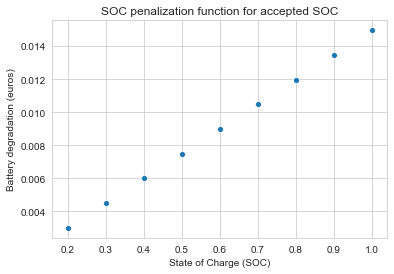

In [33]:
ax = sns.scatterplot(np.arange(0.2, 1.1,0.1), [soc_penalization(x) for x in np.arange(0.2, 1.1,0.1)])
ax.set(xlabel='State of Charge (SOC)', 
       ylabel='Battery degradation (euros)', 
       title="SOC penalization function for accepted SOC")

[Text(0.5, 0, 'Time (hours, 0=noon)'),
 Text(0, 0.5, 'Electricity price (euros)')]

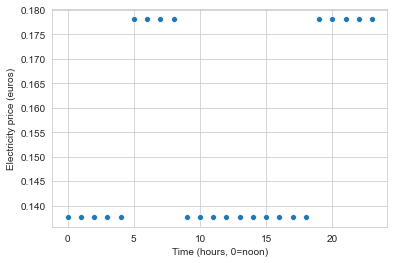

In [34]:
ax = sns.scatterplot(range(24), ELECTRICITY_COSTS)
ax.set(xlabel='Time (hours, 0=noon)', ylabel='Electricity price (euros)')

In [47]:
# Define the objective function
def cost_electricity(p):
    return sum(p_*ep for p_,ep in zip(p, ELECTRICITY_COSTS))
def cost_degradation(p):
    cost_power_charge = sum(degradation_function(p_) for p_ in p)
    socs_kwh = [Q_KWH*STATE_OF_CHARGE_T0 + p[i]/2.0 + sum(p[:(i-1)]) for i in range(T_MIN, T_MAX)]
    cost_soc = np.mean(socs_kwh)/Q_KWH
    return cost_power_charge + cost_soc
def cost_charge(p):
    ce = cost_electricity(p)
    cd = cost_degradation(p)
    return ce + cd

# Define bounds constraints
from scipy.optimize import Bounds
lb = [0]*T_MIN + [CHARGE_POWER_LOWER_BOUND_KWH]*(T_MAX-T_MIN) + [0]*(24-T_MAX)
ub = [0]*T_MIN + [CHARGE_POWER_HIGHER_BOUND_KWH]*(T_MAX-T_MIN) + [0]*(24-T_MAX)

bounds = Bounds(lb, ub)

# Define linear constraints for the SOC up to t to be within manufacturer's specified bounds, 
# and to be at least at desired SOC at T_MAX.
from scipy.optimize import LinearConstraint
m = np.tril([1]*24).reshape((24,24))
lb = np.ones((24,))*(-(STATE_OF_CHARGE_T0-STATE_OF_CHARGE_LOWER_BOUND)*Q_KWH)
lb[T_MAX:] = (STATE_OF_CHARGE_TCH-STATE_OF_CHARGE_T0)*Q_KWH
ub = np.ones((24,))*((1-STATE_OF_CHARGE_T0)*Q_KWH)
linear_constraint = LinearConstraint(m.tolist(), lb, ub)

In [48]:
# solving the problem
from scipy.optimize import minimize
p0 = [1]*24
res = minimize(cost_charge, p0, method='trust-constr', constraints=[linear_constraint],
               options={'verbose': 1}, bounds=bounds)

`gtol` termination condition is satisfied.
Number of iterations: 37, function evaluations: 700, CG iterations: 74, optimality: 7.42e-09, constraint violation: 1.26e-13, execution time: 0.64 s.


Optimal charge profile (kWh):
[-0.0, 1.2, 6.6, 6.6, 6.6, -6.6, -6.6, -6.6, -4.2, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 4.2, 6.6, 6.6, 6.6, -6.6, 1.8, 1.8, 0.0, -0.0]
Resulting vehicle charge (kWh)
[ 9.  10.2 16.8 23.4 30.  23.4 16.8 10.2  6.   6.   6.   6.   6.   6.
  6.  10.2 16.8 23.4 30.  23.4 25.2 27.  27.  27. ]
Total balance of grid = 2.8 € (electricity = 1.4 €, degradation = 1.4 €)


[Text(0.5, 0, 'Time (hours, 0=noon)'),
 Text(0, 0.5, 'Power charge (kWh)'),
 Text(0.5, 1.0, 'Optimal charge profile')]

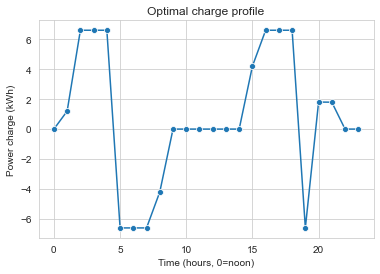

In [49]:
print('Optimal charge profile (kWh):')
solution = [round(rx,2) for rx in res.x]
print(solution)
print('Resulting vehicle charge (kWh)')
print(np.cumsum(solution) + Q_KWH*STATE_OF_CHARGE_T0)
print('Total balance of grid = {} € (electricity = {} €, degradation = {} €)'.format(round(cost_charge(res.x), 1),
                                                                            round(cost_electricity(res.x), 1),
                                                                            round(cost_degradation(res.x), 1)))
ax = sns.lineplot(range(24), res.x, marker= "o")
ax.set(xlabel='Time (hours, 0=noon)', ylabel='Power charge (kWh)', title="Optimal charge profile")